Identify cat picture.

Goal: Given an input image, figure out wether the picture is cat or not. 

Strategy: 
  <ol>Figure out framework and libraries we want to use.</ol>
  <ol>Collect the data for the prediciton. </ol>
  <ol>Create NN model.</ol>
  <ol>Train the NN model.</ol>
  <ol>Predict the output using model.</ol>

Figure out framework and libraries we want to use

Here we will going to use following libraries and packages


> Numpy <br>
> h5py : (package to interect with data stored in h5 file) <br>
> PIL : (To manipulate and save different format of image) <a href='https://en.wikipedia.org/wiki/Python_Imaging_Library'> PIL </a> <br>
> Scipy : (Contains varieties of subpackage soving various computation) <a href='https://www.scipy.org/'> Scipy </a> <br>
> matplotib : (To plot various graph) <a href='https://matplotlib.org/'> matplotlib </a>





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

Method for loading datasets. <br>
Since I am using google drive, I will upload like to mount the drive. <br>
(we can also run on local machine if we have set enviornment)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data can be in different style. <br>
i.e. It can be a big chunk and we can devide them in according our need during implimentation. <br>

<b>Note</b> : Here we have used the one which is already defined in train and test set. 

In [9]:
def load_split_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/dataset_cat_ident/datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/MyDrive/dataset_cat_ident/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [10]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_split_dataset() # Load train and test data set using method defined above

y = [1], it's a 'cat' picture.


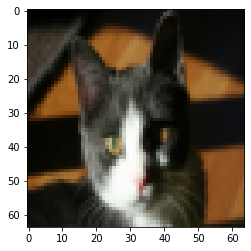

In [11]:
# Let us see the image from the train data set
# We can change the index number and see different output.
index = 19
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [15]:
# Let us check the shape of our dataset 
print('Shape of the traing set :' +str(train_set_x_orig.shape))
print('Shape of the test set :' +str(test_set_x_orig.shape))


Shape of the traing set :(209, 64, 64, 3)
Shape of the test set :(50, 64, 64, 3)


Above shape is telling us that, <br>

For training and testing we have respectively 209 and 50 samples.<br>
Middel numbers in shape indexing image width and height in pixels.<br>
The number in the end represents the number of channels we have (3-RGB).

In [16]:
# Above shape is not good as an input in the NN. So we will flatten it.
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [22]:
print(test_set_x_flatten)
print('\n After flattening the array shape of testset : ' +str(test_set_x_flatten.shape))

[[158 115 255 ...  41  18 133]
 [104 110 253 ...  47  18 163]
 [ 83 111 254 ...  84  16  75]
 ...
 [173 171 133 ... 183 144   5]
 [128 176 101 ... 141 137  22]
 [110 186 121 ... 116 108   5]]

 After flattening the array shape of testset : (12288, 50)


RGB channel would have values between 0-255. <br>
It would be effective for computation, if we could stadardize the datasets.<br>
One way to do that is normalize it (dividing dataset by highest number *255*).


In [23]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

Now let us create a model. <br>
We want to bulid a model which can take input image in pixel (*nomalized*) format.<br>
We will find forward propagoation using input and assigning weights to it using, <br>
For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 

Then will find loss for it using, <br>
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

**Note**: Here we are usign sigmoid function since we want output as, ***cat*** or ***not cat*** <br>

For sigmoid function formula is: <br> 
$$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$ 

In [25]:
# creating sigmid function 
def sigmoid(z):

    s = 1 / (1 + (np.exp(-z)))
    
    return s

In [26]:
# Intializing weights for w and b
def initialize_with_zeros(dim):
    
    w = np.zeros((dim, 1))
    b = 0
    
    # To avoid the bug in code one was is to assert it.
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [27]:
# Computing forward backward propagation 

def f_b_propagate(w, b, X, Y):

    m = X.shape[1]
    
    # FORWARD PROPAGATION 
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    #cost = - (1/m) * (np.dot(Y,np.log(A.T)) + np.dot((1-Y),np.log(1-A.T))) # compute cost
    cost = -1 / m * np.sum(Y*np.log(A)+(1-Y)*np.log(1-A), axis = 1, keepdims = True)
    
    
    # BACKWARD PROPAGATION 
    dw = (1/m) * np.dot(X, (A-Y).T)  
    db = (1/m) * np.sum(A-Y)
    
    cost = np.squeeze(cost)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    # save to value in dictionary 
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [28]:
# Optimzing weight by updating them in each iteration 

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        
        grads, cost = f_b_propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [29]:
# Make prediciton using train model

def predict(w, b, X):

    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    # We will set our threshold at 0.5 for deciding wether it is cat or not
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [30]:
# Creating model by merging some of the above functions 

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [31]:
# Train and check the accuracy of model on train and test set

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


From above train and test scores we can say that our model is overfitting.

In [53]:
print(d['Y_prediction_test'][0,12])
print(test_set_y[0,15])
test_set_x.shape

1.0
1


(12288, 50)

y = 1, it's a 'cat' picture.


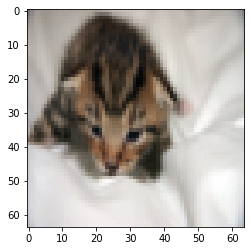

In [61]:
index = 1
plt.imshow(test_set_x[:,index].reshape((64, 64, 3)))
print ("y = " + str(test_set_y[0,index]) + ", it's a '" + classes[int(d["Y_prediction_test"][0,index])].decode('utf-8')+  "' picture.")

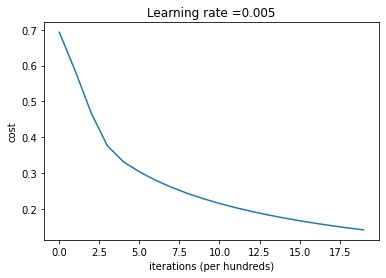

In [62]:
# Learning rate per iteration  
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

****************************************

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

****************************************

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

****************************************



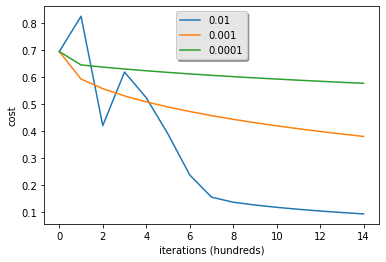

In [63]:
# Let us check how it generates different results according to varying learnig rates 

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "****************************************" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()